In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,classification_report
from imblearn.over_sampling import SMOTE
import numpy as np # linear algebra
from abc import ABC, abstractmethod
from sklearn.base import TransformerMixin, clone
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import f_classif,chi2, mutual_info_classif, SelectKBest, RFE, SelectFromModel
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reduce the size of your train and test data to model more easily
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df = pd.read_csv('/content/pokemonnumber2.csv')

In [4]:
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [6]:
df.describe()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,781.000000,801.000000,703.000000,801.000000,801.000000,801.000000,801.000000,781.000000,801.000000,801.000000
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,...,1.163892,68.958801,55.155761,401.000000,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,...,1.080326,26.576015,20.261623,231.373075,32.353826,27.942501,28.907662,109.354766,1.930420,0.282583
min,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,...,0.100000,1.000000,0.000000,1.000000,10.000000,20.000000,5.000000,0.100000,1.000000,0.000000
25%,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,...,0.600000,50.000000,50.000000,201.000000,45.000000,50.000000,45.000000,9.000000,2.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,65.000000,50.000000,401.000000,65.000000,66.000000,65.000000,27.300000,4.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.500000,80.000000,50.000000,601.000000,91.000000,90.000000,85.000000,64.800000,5.000000,0.000000
max,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,14.500000,255.000000,100.000000,801.000000,194.000000,230.000000,180.000000,999.900000,7.000000,1.000000


In [7]:
df.isnull().sum()

abilities              0
against_bug            0
against_dark           0
against_dragon         0
against_electric       0
against_fairy          0
against_fight          0
against_fire           0
against_flying         0
against_ghost          0
against_grass          0
against_ground         0
against_ice            0
against_normal         0
against_poison         0
against_psychic        0
against_rock           0
against_steel          0
against_water          0
attack                 0
base_egg_steps         0
base_happiness         0
base_total             0
capture_rate           0
classfication          0
defense                0
experience_growth      0
height_m              20
hp                     0
japanese_name          0
name                   0
percentage_male       98
pokedex_number         0
sp_attack              0
sp_defense             0
speed                  0
type1                  0
type2                384
weight_kg             20
generation             0


In [8]:
# Search the column names with missing values
cols_missing_val = df.columns[df.isnull().any()].tolist()

for col in cols_missing_val:
    print("%s : %d" % (col, df[col].isnull().sum()))

height_m : 20
percentage_male : 98
type2 : 384
weight_kg : 20


## **here, we fill the missing**

In [9]:
#Hence genderless pokemons can be assigned '-1'
df['percentage_male'].fillna(int(-1), inplace=True)

In [10]:
#Unique values
df['type2'].unique()

array(['poison', nan, 'flying', 'dark', 'electric', 'ice', 'ground',
       'fairy', 'grass', 'fighting', 'psychic', 'steel', 'fire', 'rock',
       'water', 'dragon', 'ghost', 'bug', 'normal'], dtype=object)

In [11]:
#Replace nan with new type2
df['type2'].fillna('hormann', inplace=True)

In [12]:
#Replace the missing values with 0.
df['height_m'].fillna(int(0), inplace=True)
df['weight_kg'].fillna(int(0), inplace=True)

In [13]:
#Memory Consumption
mem = df.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   0.25067901611328125 MB


In [14]:
df.isnull().values.any()

False

In [15]:
df = reduce_mem_usage(df, verbose=True)

Mem. usage decreased to  0.13 Mb (49.4% reduction)


In [16]:
#Classfication
df['classfication'].nunique()

588

preprosseing for make it int

In [17]:
df.dtypes

abilities             object
against_bug          float32
against_dark         float32
against_dragon       float32
against_electric     float32
against_fairy        float32
against_fight        float32
against_fire         float32
against_flying       float32
against_ghost        float32
against_grass        float32
against_ground       float32
against_ice          float32
against_normal       float32
against_poison       float32
against_psychic      float32
against_rock         float32
against_steel        float32
against_water        float32
attack                 int16
base_egg_steps         int16
base_happiness         int16
base_total             int16
capture_rate          object
classfication         object
defense                int16
experience_growth      int32
height_m             float32
hp                     int16
japanese_name         object
name                  object
percentage_male      float32
pokedex_number         int16
sp_attack              int16
sp_defense    

In [18]:
for label,content in df.items():
    if pd.api.types.is_float_dtype(content):
        df[label] = df[label].astype('int')

In [19]:
for label,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = df[label].astype('category')


In [20]:
for label,content in df.items():
    if pd.api.types.is_categorical_dtype(content):
        df[label] = pd.Categorical(content).codes + 1

In [21]:
df.dtypes

abilities            int16
against_bug          int64
against_dark         int64
against_dragon       int64
against_electric     int64
against_fairy        int64
against_fight        int64
against_fire         int64
against_flying       int64
against_ghost        int64
against_grass        int64
against_ground       int64
against_ice          int64
against_normal       int64
against_poison       int64
against_psychic      int64
against_rock         int64
against_steel        int64
against_water        int64
attack               int16
base_egg_steps       int16
base_happiness       int16
base_total           int16
capture_rate          int8
classfication        int16
defense              int16
experience_growth    int32
height_m             int64
hp                   int16
japanese_name        int16
name                 int16
percentage_male      int64
pokedex_number       int16
sp_attack            int16
sp_defense           int16
speed                int16
type1                 int8
t

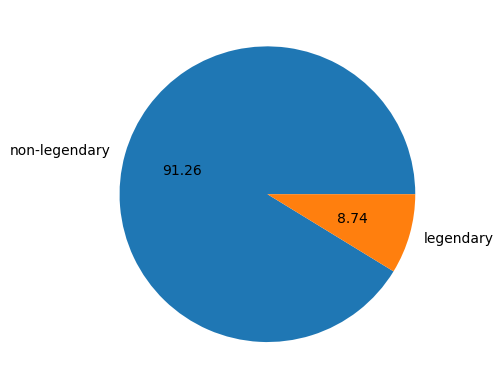

In [22]:
#just for show
plt.pie(x=df['is_legendary'].value_counts(),autopct='%0.2f',labels=['non-legendary','legendary'])
plt.show()

## ***Model Training SVC ***


## Train test split

In [23]:
X_old= df.drop(labels= 'is_legendary', axis= 1)
y_old = df['is_legendary']

In [24]:
model_a = SVC()
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X_old, y_old, test_size=0.3)
model_a.fit(X_train_old, y_train_old)
model_a.score(X_test_old, y_test_old)

0.9004149377593361

In [25]:
from sklearn.metrics import classification_report

# Make predictions
y_pred_old = model_a.predict(X_test_old)

# Calculate metrics
report = classification_report(y_test_old, y_pred_old)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       217
           1       0.00      0.00      0.00        24

    accuracy                           0.90       241
   macro avg       0.45      0.50      0.47       241
weighted avg       0.81      0.90      0.85       241



# **Feature selection**

In [26]:
y = df['is_legendary']

In [27]:
#noha
def calculate_accuracy(x):
    X=df[x]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30)
    lgt_R = LogisticRegression(solver='lbfgs')
    lgt_R.fit(X_train, y_train)
    accuracy=lgt_R.score(X_test,y_test)
    print('Accuracy:',accuracy)

    y_pred = lgt_R.predict(X_test)
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    return accuracy, classification_report(y_test, y_pred)

In [28]:
X=df.drop(labels= 'is_legendary', axis= 1).columns.values.tolist()#columnsName->X

In [29]:
import random
columnsName1=[0,1]
chromosomes=[]
for i in range(10):
    chro1=[]
    for i in range(40):
        item = random.choice(tuple(columnsName1))
        chro1.append(item)
    chromosomes.append(chro1)

In [30]:
def data(chromosomes1):
    chromosomes2=[]
    for i in range(len(chromosomes1)):
        if chromosomes1[i]==1:
                chromosomes2.append(X[i])
    return chromosomes2

the final accuracy for

In [31]:
pb=[]
def checkpersonalnest():
    for i in range(len(chromosomes)):
         pb.append(calculate_accuracy(data(chromosomes[i])))
checkpersonalnest()

Accuracy: 0.921161825726141
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       219
           1       0.67      0.27      0.39        22

    accuracy                           0.92       241
   macro avg       0.80      0.63      0.67       241
weighted avg       0.91      0.92      0.91       241

Accuracy: 0.946058091286307
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       217
           1       0.82      0.58      0.68        24

    accuracy                           0.95       241
   macro avg       0.89      0.78      0.83       241
weighted avg       0.94      0.95      0.94       241

Accuracy: 0.9336099585062241
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       230
           1       0.14      0.09      0.11        11

    accuracy                

# **PSO**

In [32]:
def checkvelocity(globalbest):
    velocity=[]
    for j in range(len(chromosomes)):
        velocity.append(list(0+1*(np.random.random(1)[0])*(np.array(chromosomes[j])-np.array(chromosomes[j]))+1*(np.random.random(1)[0])*(np.array(globalbest)-np.array(chromosomes[j]))))
    #print(velocity)
    return velocity


In [33]:
def addingchromosomes(velocity):
    chromosomes2=[]
    for i in range(len(velocity)):
        nextchromo=[]
        for j in range(len(velocity[i])):
            nextchromo.append(chromosomes[i][j]+velocity[i][j])
        chromosomes2.append(nextchromo)
    return chromosomes2

In [34]:
def normalize(chromosomes2):
    for l in range(len(chromosomes2)):
        for m in range(len(chromosomes2[l])):
            if chromosomes2[l][m]>0.5:
                chromosomes2[l][m]=1
            else:
                chromosomes2[l][m]=0
    return chromosomes2

In [35]:
def checkpd(chromosomes2):
    personal=[]
    for i in range(len(chromosomes2)):
        personal.append(calculate_accuracy(data(chromosomes2[i])))
    for j in range(len(personal)):
        if(personal[j]>pb[j]):
            chromosomes[j]=chromosomes2[j]
            pb[j]=personal[j]
    return personal

In [36]:
max(pb)
ind = pb.index(max(pb))
globalbest=chromosomes[ind]
for i in range(30):
    chromosomes2=[]
    personal=[]
    velocity=checkvelocity(globalbest)
    chromosomes2=addingchromosomes(velocity)
    chromosomes2=normalize(chromosomes2)
    personal=checkpd(chromosomes2)
    globalbest=[]
    max(pb)
    ind = pb.index(max(pb))
    globalbest=chromosomes[ind]


Accuracy: 0.979253112033195
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       223
           1       0.88      0.83      0.86        18

    accuracy                           0.98       241
   macro avg       0.93      0.91      0.92       241
weighted avg       0.98      0.98      0.98       241

Accuracy: 0.950207468879668
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       218
           1       1.00      0.48      0.65        23

    accuracy                           0.95       241
   macro avg       0.97      0.74      0.81       241
weighted avg       0.95      0.95      0.94       241

Accuracy: 0.983402489626556
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       224
           1       0.88      0.88      0.88        17

    accuracy                 

In [37]:
max(pb)

(1.0,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       223\n           1       1.00      1.00      1.00        18\n\n    accuracy                           1.00       241\n   macro avg       1.00      1.00      1.00       241\nweighted avg       1.00      1.00      1.00       241\n')

In [38]:
ind = pb.index(max(pb))
print(ind)
globalbest=chromosomes[ind]

9


# **Selected feature**

In [39]:
print(data(globalbest))

['abilities', 'against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fire', 'against_flying', 'against_grass', 'against_ground', 'against_normal', 'attack', 'base_egg_steps', 'base_total', 'classfication', 'defense', 'japanese_name', 'name', 'percentage_male', 'pokedex_number', 'sp_defense', 'weight_kg']


In [40]:
print(globalbest)#new X

[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]


## **#this is another way to find the feature selection**

In [41]:
# negative_values = X[X < 0]
# if len(negative_values) > 0:
#     raise ValueError("Input X contains negative values.")

In [42]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel
# from sklearn.svm import SVC

# this_model = RandomForestClassifier(n_estimators=20)
# sel= SelectFromModel(estimator= this_model)
# sel.fit(X,y)
# selected_feature= sel.transform(X)

In [43]:
# sel.get_support()

In [44]:
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC

# # Assuming X and y are defined and the SelectFromModel process is completed

# # Perform train-test split on the selected features
# X_train, X_test, y_train, y_test = train_test_split(globalbest, y, test_size=0.3)

# # Train SVC model
# model_svc = SVC()
# model_svc.fit(X_train, y_train)

# # Evaluate model
# accuracy = model_svc.score(X_test, y_test)
# print("Accuracy:", accuracy)


## **this the hyper parameter**

In [45]:
import pandas as pd
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier

X_hyper= df.drop(labels= 'is_legendary', axis= 1)
y_hyper = df['is_legendary']

# Split data into train and test sets
X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(X_hyper, y_hyper, test_size=0.3, random_state=42)

# Choose model
model = RandomForestClassifier()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Set up Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

# Perform Grid Search
grid_search.fit(X_train_hyper, y_train_hyper)

# Get best hyperparameters
best_params = grid_search.best_params_

# Train model with best hyperparameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_hyper, y_train_hyper)

# Evaluate model
accuracy = best_model.score(X_test_hyper, y_test_hyper)
print("Accuracy:", accuracy)


Accuracy: 0.995850622406639
